This notebook demonstrates how to load and validate tabular data for classification tasks using standard Python libraries. We'll cover:

1. Loading tabular data with pandas
2. Data validation and quality checks
3. Basic data exploration and statistics
4. Data visualization and relationships

The data format follows these requirements:
- Each row represents a unique sample with a distinct sample_id
- Features are numeric values used for classification
- Labels represent classification groups (can be repeated across samples)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import toml
from typing import Dict, Any

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def load_config(config_path: str) -> Dict[str, Any]:
    """
    Load configuration from a TOML file.
    
    Args:
        config_path: Path to the TOML configuration file
        
    Returns:
        Dictionary containing the configuration parameters
    """
    try:
        config = toml.load(config_path)
        print("Configuration loaded successfully!")
        return config
    except Exception as e:
        print(f"Error loading configuration: {str(e)}")
        raise

# Load configuration
config = load_config(Path('../config.toml'))

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])


Configuration loaded successfully!


## 1. Load Test Data

We'll use the test data file located at `data/test_input.csv`. This file contains:
1. Unique sample identifiers (sample_id)
2. 5 numeric features (feature_1 through feature_5)
3. Categorical labels (A, B, C) for classification groups
4. 10 sample rows for basic testing

The data structure follows these rules:
- Each row represents a unique sample with a distinct sample_id
- Features are numeric values for classification
- Labels can be repeated as they represent classification groups

Let's load and examine this data:


In [2]:
# Load the data using config
data_config = config['data']
data_path = data_config['input_path']
df = pd.read_csv(data_path)

# Get column names from config
sample_id_col = data_config['sample_id_column']
label_col = data_config['label_column']

# Get feature columns
if data_config['feature_columns']:
    # Use explicitly specified feature columns
    feature_cols = data_config['feature_columns']
else:
    # Auto-detect feature columns (all numeric columns except sample_id and label)
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if sample_id_col in feature_cols:
        feature_cols.remove(sample_id_col)
    if label_col in feature_cols:
        feature_cols.remove(label_col)

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 40)
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"Number of unique samples: {df[sample_id_col].nunique()}")
print(f"Unique labels: {df[label_col].unique()}")
print(f"Label distribution: {df[label_col].value_counts().to_dict()}")

# Basic data validation
print("\nData Validation:")
print("-" * 40)

# Check for duplicate sample IDs
if len(df) != df[sample_id_col].nunique():
    print("\nWARNING: Duplicate sample IDs found!")
    duplicates = df[df[sample_id_col].duplicated(keep=False)]
    print(duplicates[[sample_id_col, label_col]])

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("\nWARNING: Missing values found:")
    print(missing_values[missing_values > 0])

print("\nFirst few rows:")
print(df.head())

# Display basic statistics of features
print("\nFeature Statistics:")
print(df[feature_cols].describe())


Dataset Info:
----------------------------------------
Number of samples: 10
Number of features: 5
Feature names: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
Number of unique samples: 10
Unique labels: ['A' 'B' 'C']
Label distribution: {'A': 4, 'B': 3, 'C': 3}

Data Validation:
----------------------------------------

First few rows:
    sample_id  feature_1  feature_2  feature_3  feature_4  feature_5 label
0  SAMPLE_001      0.497      0.138      0.648      0.173      0.525     A
1  SAMPLE_002     -0.234     -0.234      0.767      0.839      0.741     B
2  SAMPLE_003      0.423      0.291      0.334      0.176      0.670     A
3  SAMPLE_004      0.862      0.317      0.860      0.181      0.183     C
4  SAMPLE_005     -0.103      0.155      0.302      0.525      0.432     B

Feature Statistics:
       feature_1  feature_2  feature_3  feature_4  feature_5
count     10.000     10.000     10.000     10.000     10.000
mean       0.367      0.192      0.513      0.36

## 2. Data Validation

Let's perform some basic validation checks on our test data:
1. Check for missing values
2. Verify data types (numeric features, categorical labels)
3. Check value ranges and distributions
4. Validate label categories


In [3]:
# 1. Check for missing values
print("Missing Values Check:")
print("-" * 40)
print(df.isnull().sum())

# 2. Verify data types
print("\nData Types Check:")
print("-" * 40)
print(df.dtypes)

# 3. Validate sample_ids
print("\nSample ID Validation:")
print("-" * 40)
print(f"Number of sample_ids: {len(df['sample_id'])}")
print(f"Number of unique sample_ids: {df['sample_id'].nunique()}")
if len(df['sample_id']) != df['sample_id'].nunique():
    print("WARNING: Duplicate sample_ids found!")
    print("\nDuplicate sample_ids:")
    print(df['sample_id'].value_counts()[df['sample_id'].value_counts() > 1])

# 4. Check value ranges for numeric features
print("\nValue Ranges for Features:")
print("-" * 40)
for col in df.columns[1:-1]:  # Exclude sample_id and label columns
    print(f"{col}:")
    print(f"  Min: {df[col].min():.3f}")
    print(f"  Max: {df[col].max():.3f}")
    print(f"  Mean: {df[col].mean():.3f}")
    print(f"  Std: {df[col].std():.3f}")

# 5. Validate labels
print("\nLabel Distribution:")
print("-" * 40)
print("Label counts:")
print(df['label'].value_counts())
print("\nSamples per label:")
for label in df['label'].unique():
    print(f"\nLabel {label}:")
    print(df[df['label'] == label]['sample_id'].tolist())


Missing Values Check:
----------------------------------------
sample_id    0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
label        0
dtype: int64

Data Types Check:
----------------------------------------
sample_id     object
feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
label         object
dtype: object

Sample ID Validation:
----------------------------------------
Number of sample_ids: 10
Number of unique sample_ids: 10

Value Ranges for Features:
----------------------------------------
feature_1:
  Min: -0.234
  Max: 0.862
  Mean: 0.367
  Std: 0.415
feature_2:
  Min: -0.234
  Max: 0.526
  Mean: 0.192
  Std: 0.264
feature_3:
  Min: 0.236
  Max: 0.860
  Mean: 0.513
  Std: 0.247
feature_4:
  Min: 0.173
  Max: 0.839
  Mean: 0.367
  Std: 0.272
feature_5:
  Min: 0.183
  Max: 0.741
  Mean: 0.562
  Std: 0.167

Label Distribution:
----------------------------------------
Label counts:
label
A   

## 3. Data Visualization

### Label distribution

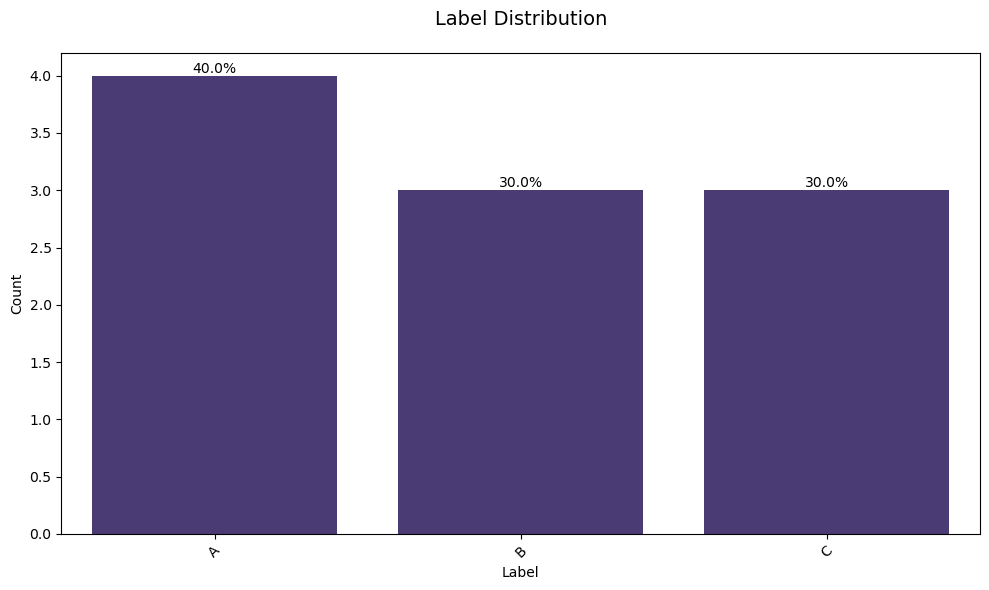

In [4]:
# Set default visualization parameters
default_fig_size = (15, 10)
default_color_palette = 'viridis'

# Get visualization settings from config if available
viz_config = config.get('visualization', {})
fig_size = viz_config.get('figure_size', default_fig_size)
color_palette = viz_config.get('color_palette', default_color_palette)

# Set color palette
sns.set_palette(color_palette)

# Function to select top features by variance
def select_top_features(data, feature_cols, n=100):
    """Select top N features by variance."""
    variances = data[feature_cols].var().sort_values(ascending=False)
    return variances.head(n).index.tolist()

# Function to create feature correlation matrix
def compute_feature_correlations(data, features):
    """Compute correlation matrix for selected features."""
    return data[features].corr()

# 1. Label Distribution Analysis
plt.figure(figsize=fig_size)
plt.title('Label Distribution', pad=20, fontsize=14)
sns.countplot(data=df, x=label_col)
plt.xticks(rotation=45)
plt.xlabel('Label')
plt.ylabel('Count')

# Add percentage labels on top of bars
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()




Generating Feature Distribution Heatmap...


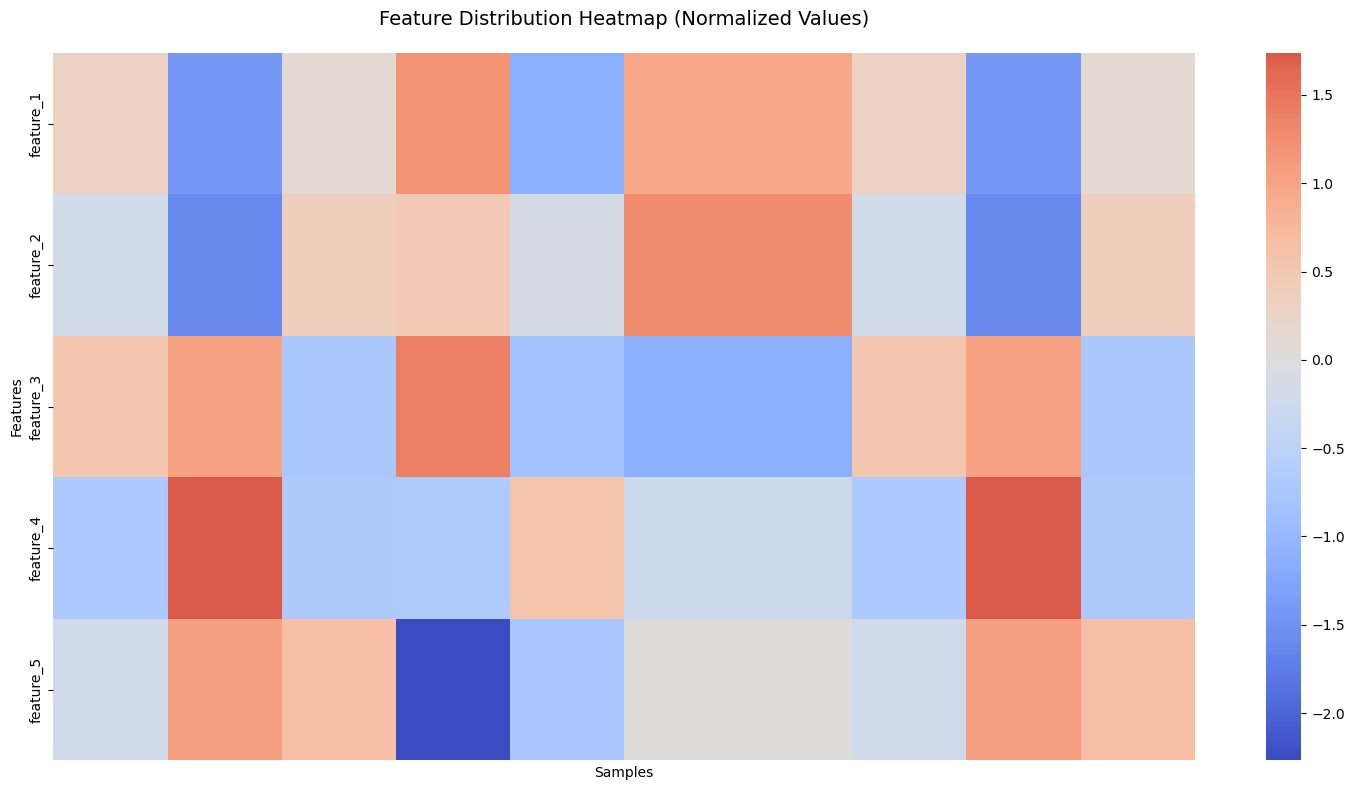

In [5]:
# 2. Feature Distribution Heatmap
print("\nGenerating Feature Distribution Heatmap...")
# Select top features by variance if there are too many
n_features = len(feature_cols)
if n_features > 100:
    print(f"Selecting top 100 features by variance out of {n_features} total features")
    selected_features = select_top_features(df, feature_cols, n=100)
else:
    selected_features = feature_cols

# Create feature distribution heatmap
plt.figure(figsize=(15, 8))
plt.title('Feature Distribution Heatmap (Normalized Values)', pad=20, fontsize=14)

# Normalize and plot feature values
feature_data = df[selected_features].apply(lambda x: (x - x.mean()) / x.std())
sns.heatmap(feature_data.T, cmap='coolwarm', center=0, 
            yticklabels=True, xticklabels=False)
plt.xlabel('Samples')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Feature correlations


Generating Feature Correlation Analysis...


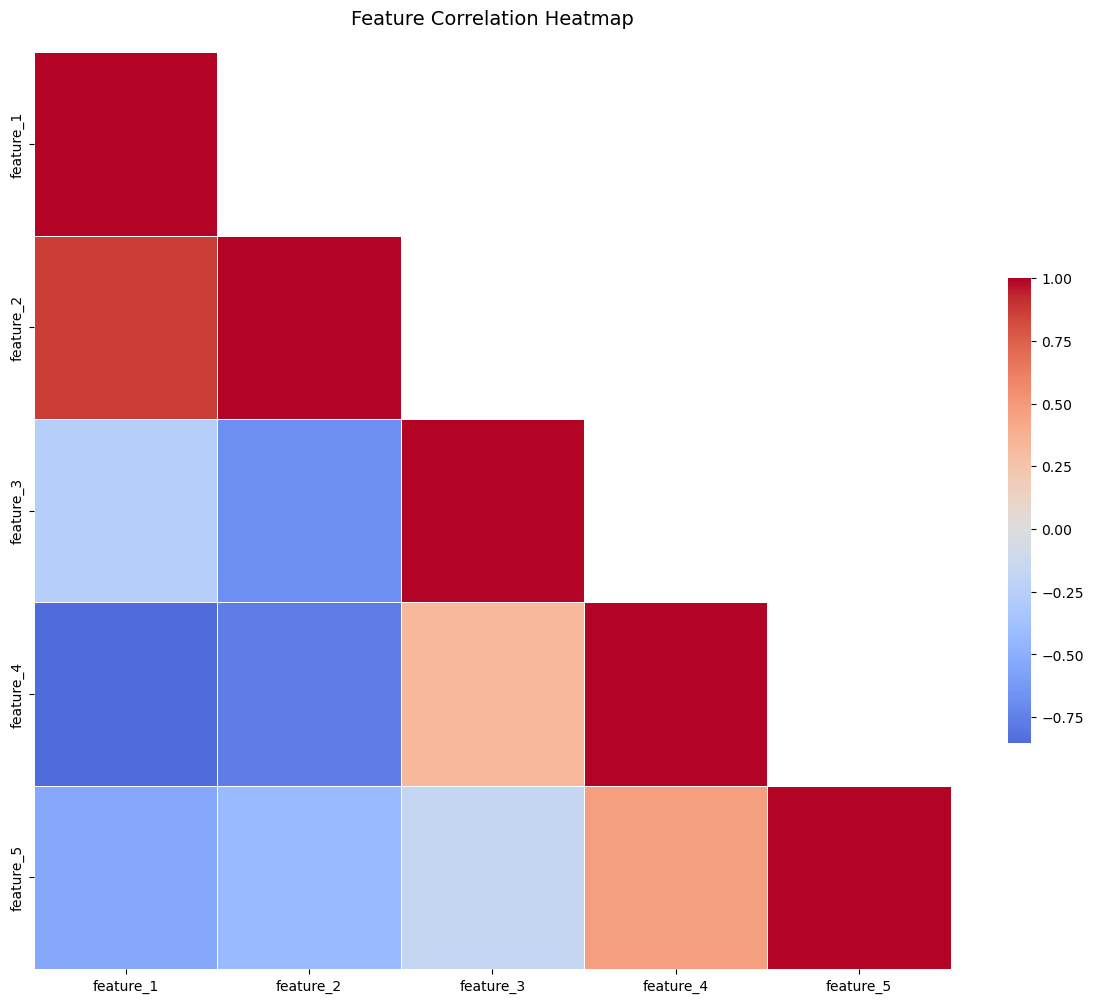

In [6]:
# 3. Feature Correlation Analysis
print("\nGenerating Feature Correlation Analysis...")
# Compute correlations for selected features
correlation_matrix = compute_feature_correlations(df, selected_features)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
plt.title('Feature Correlation Heatmap', pad=20, fontsize=14)
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.show()

### PCA


Performing PCA Analysis...


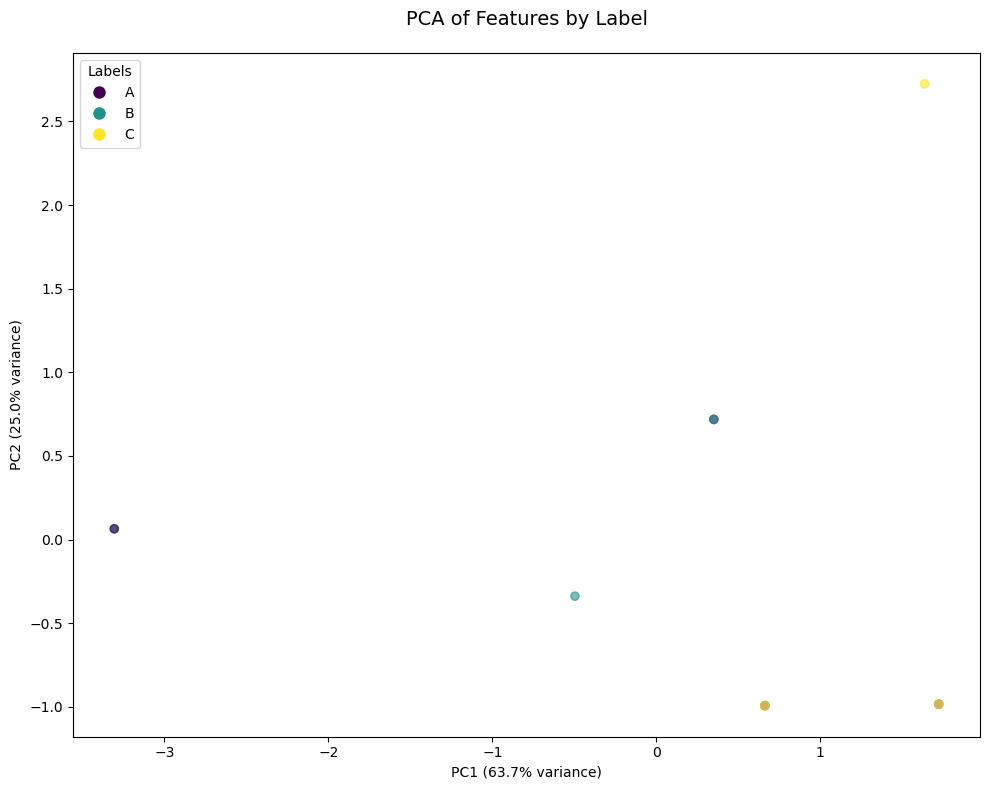


Top Features by Contribution to Principal Components:

Top 10 Most Important Features:
             PC1    PC2  total_importance
feature_3 -0.283  0.733             1.016
feature_5 -0.319 -0.628             0.947
feature_2  0.537 -0.202             0.739
feature_1  0.524  0.145             0.669
feature_4 -0.506 -0.078             0.584


In [7]:
# 4. PCA Analysis
print("\nPerforming PCA Analysis...")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data for PCA
X = df[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA plot
plt.figure(figsize=(10, 8))
plt.title('PCA of Features by Label', pad=20, fontsize=14)

# Create scatter plot with labels
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=pd.factorize(df[label_col])[0],
                     cmap='viridis', alpha=0.6)

# Add legend
unique_labels = df[label_col].unique()
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=scatter.cmap(scatter.norm(i)), 
                            label=label, markersize=10)
                  for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Labels')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nTop Features by Contribution to Principal Components:")
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)
feature_importance['total_importance'] = np.abs(feature_importance).sum(axis=1)
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('total_importance', ascending=False).head(10))